In [485]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid, train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
from collections import Counter
from ieseg_credscore import WOEEncoder
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import plotly.graph_objs as go

# Final Project Credit Scoring Part 1

DIAZ GONZALEZ MANJARREZ Fernando

# Read Data

In [373]:
#Define path
path=r"C:\Users\fdiazgonzalezmanja\Documents\MBD_courses\Credit_Scoring\Individual_project\Assignment_Data_2023"

In [374]:
#Read data
loan_accept = pd.read_csv(path+r"\RealEstateLoans_accepts.csv")
loan_reject = pd.read_csv(path+r"\RealEstateLoans_rejects.csv")

# Pre-processing

## Handling null values

In [375]:
def check_na(df):
    row_na=df[df.isna().any(axis=1)].shape[0]
    tot_rows=df.shape[0]
    per_row=round(row_na/tot_rows,2)
    return format(row_na, ','), per_row, tot_rows

In [376]:
#Quick check for NA's

#Rows with at least one NA
na_accept=check_na(loan_accept)
na_reject=check_na(loan_reject)

print("Number of Na's on the accept set: "+str(na_accept[0])+' which is '+str(na_accept[1])+'%')
print("Number of Na's on the reject set: "+str(na_reject[0])+' which is '+str(na_reject[1])+'%')

Number of Na's on the accept set: 13,515 which is 0.73%
Number of Na's on the reject set: 6,737 which is 0.74%


Although there are some NA's the percentage of NA's is quite low, we will print where exaclty the NA's are for the columns to see how we will proceed with them

In [377]:
loan_accept.isna().sum()

total_income                   0
loan_amount                    0
term                           0
interest_rate                  0
own_car                        0
own_house                      0
nr_children                    0
income_type                    0
education_type                 0
family_status                  0
housing_type                   0
region_population_ratio        0
days_birth                     0
days_employed                  0
days_registration              0
mobile_number                  0
phone_number                   0
email                          0
days_phone_change              0
occupation_type             5922
family_count                   0
EXT1                       10415
EXT2                          33
EXT3                        3640
EXT4                           0
EXT5                           0
EXT6                           0
EXT7                           0
Default                        0
days_payment_arrears           0
dtype: int

In [378]:
loan_reject.isna().sum()

total_income                  0
loan_amount                   0
term                          0
interest_rate                 0
own_car                       0
own_house                     0
nr_children                   0
income_type                   0
education_type                0
family_status                 0
housing_type                  0
region_population_ratio       0
days_birth                    0
days_employed                 0
days_registration             0
mobile_number                 0
phone_number                  0
email                         0
days_phone_change             0
occupation_type            2751
family_count                  0
EXT1                       5273
EXT2                         16
EXT3                       1812
EXT4                          0
EXT5                          0
EXT6                          0
EXT7                          0
dtype: int64

As seen above, the NA's are only in the columns Occupation_type (which is categorical), EXT1 (float), EXT2(float), EXT3(float); to treat the missing values for the occupational type for now will put them as missing, in the following steps we will see if it can be joined with any other category

In [379]:
loan_accept.loc[loan_accept['occupation_type'].isna(),'occupation_type']='missing'
loan_reject.loc[loan_reject['occupation_type'].isna(),'occupation_type']='missing'

In [380]:
#Rows with at least one NA
na_accept=check_na(loan_accept)
na_reject=check_na(loan_reject)

print("Number of Na's on the accept set: "+str(na_accept[0])+' which is '+str(na_accept[1])+'%')
print("Number of Na's on the reject set: "+str(na_reject[0])+' which is '+str(na_reject[1])+'%')

Number of Na's on the accept set: 11,876 which is 0.64%
Number of Na's on the reject set: 5,984 which is 0.66%


As we can see we still have some NA's on the data set, nevertheless, they do not represent even 1% of the data, thus for now we will drop them

In [381]:
loan_accept.dropna(inplace=True)
loan_reject.dropna(inplace=True)

In [382]:
#Rows with at least one NA
na_accept=check_na(loan_accept)
na_reject=check_na(loan_reject)

print("Number of Na's on the accept set: "+str(na_accept[0])+' which is '+str(na_accept[1])+'%')
print("Number of Na's on the reject set: "+str(na_reject[0])+' which is '+str(na_reject[1])+'%')

Number of Na's on the accept set: 0 which is 0.0%
Number of Na's on the reject set: 0 which is 0.0%


## Checking types and ranges

In [383]:
loan_accept.dtypes

total_income               float64
loan_amount                float64
term                         int64
interest_rate              float64
own_car                     object
own_house                   object
nr_children                  int64
income_type                 object
education_type              object
family_status               object
housing_type                object
region_population_ratio    float64
days_birth                   int64
days_employed                int64
days_registration          float64
mobile_number                int64
phone_number                 int64
email                        int64
days_phone_change          float64
occupation_type             object
family_count               float64
EXT1                       float64
EXT2                       float64
EXT3                       float64
EXT4                         int64
EXT5                         int64
EXT6                         int64
EXT7                         int64
Default             

In [384]:
loan_reject.dtypes

total_income               float64
loan_amount                float64
term                         int64
interest_rate              float64
own_car                     object
own_house                   object
nr_children                  int64
income_type                 object
education_type              object
family_status               object
housing_type                object
region_population_ratio    float64
days_birth                   int64
days_employed                int64
days_registration          float64
mobile_number                int64
phone_number                 int64
email                        int64
days_phone_change          float64
occupation_type             object
family_count               float64
EXT1                       float64
EXT2                       float64
EXT3                       float64
EXT4                         int64
EXT5                         int64
EXT6                         int64
EXT7                         int64
dtype: object

We should chang the variables own_car and own_house as they seem to be in an string where they should be integer(binary)

In [385]:
#Do it for the accept ones in own car
loan_accept.loc[loan_accept['own_car']=='Y','own_car']=1
loan_accept.loc[loan_accept['own_car']=='N','own_car']=0
loan_accept['own_car']=loan_accept['own_car'].astype('int64')

#Do it for the accept ones in own house
loan_accept.loc[loan_accept['own_house']=='Y','own_house']=1
loan_accept.loc[loan_accept['own_house']=='N','own_house']=0
loan_accept['own_house']=loan_accept['own_house'].astype('int64')

#Do it for the reject ones in own car
loan_reject.loc[loan_reject['own_car']=='Y','own_car']=1
loan_reject.loc[loan_reject['own_car']=='N','own_car']=0
loan_reject['own_car']=loan_reject['own_car'].astype('int64')

#Do it for the accept ones in own house
loan_reject.loc[loan_reject['own_house']=='Y','own_house']=1
loan_reject.loc[loan_reject['own_house']=='N','own_house']=0
loan_reject['own_house']=loan_reject['own_house'].astype('int64')

## Ranges

In [386]:
loan_accept.describe()

total_income   loan_amount         term  interest_rate      own_car  \
count  6.673000e+03  6.673000e+03  6673.000000    6673.000000  6673.000000   
mean   1.802177e+05  6.550046e+05    31.894500       3.347144     0.387832   
std    1.056140e+05  4.205986e+05    15.817595       0.612800     0.487292   
min    2.700000e+04  4.500000e+04    12.000000       1.024050     0.000000   
25%    1.125000e+05  3.140550e+05    18.000000       2.986653     0.000000   
50%    1.575000e+05  5.450400e+05    30.000000       3.394011     0.000000   
75%    2.250000e+05  9.000000e+05    42.000000       3.768280     1.000000   
max    3.600000e+06  4.050000e+06    60.000000       5.310851     1.000000   

         own_house  nr_children  region_population_ratio    days_birth  \
count  6673.000000  6673.000000              6673.000000   6673.000000   
mean      0.661921     0.515061                 0.020878 -14909.438034   
std       0.473091     0.770866                 0.013987   3873.040983   
min       0.000000     0.000000                 0.000533 -25165.000000   
25%       0.000000     0.000000                 0.010006 -17621.000000   
50%       1.000000     0.000000                 0.018801 -14315.000000   
75%       1.000000     1.000000                 0.028663 -11744.000000   
max       1.000000     9.000000                 0.072508  -7729.000000   

       days_employed  ...  family_count         EXT1         EXT2  \
count    6673.000000  ...   6673.000000  6673.000000  6673.000000   
mean    33614.887307  ...      2.275438     0.506803     0.528454   
std    109250.732281  ...      0.944642     0.209449     0.182828   
min    -17170.000000  ...      1.000000     0.019207     0.000013   
25%     -2985.000000  ...      2.000000     0.342483     0.425190   
50%     -1465.000000  ...      2.000000     0.511278     0.574664   
75%      -534.000000  ...      3.000000     0.678344     0.669435   
max    365243.000000  ...     10.000000     0.941433     0.821394   

              EXT3    EXT4         EXT5    EXT6         EXT7      Default  \
count  6673.000000  6673.0  6673.000000  6673.0  6673.000000  6673.000000   
mean      0.495013     0.0     0.813877     0.0     0.014836     0.072981   
std       0.195986     0.0     0.389235     0.0     0.120905     0.260124   
min       0.000527     0.0     0.000000     0.0     0.000000     0.000000   
25%       0.355639     0.0     1.000000     0.0     0.000000     0.000000   
50%       0.517297     0.0     1.000000     0.0     0.000000     0.000000   
75%       0.652897     0.0     1.000000     0.0     0.000000     0.000000   
max       0.887664     0.0     1.000000     0.0     1.000000     1.000000   

       days_payment_arrears  
count           6673.000000  
mean              23.300315  
std               46.916960  
min                0.000000  
25%                0.000000  
50%                0.000000  
75%               27.000000  
max              230.000000  

[8 rows x 25 columns]

In [387]:
loan_reject.describe()

total_income   loan_amount         term  interest_rate      own_car  \
count  3.128000e+03  3.128000e+03  3128.000000    3128.000000  3128.000000   
mean   1.746103e+05  6.485025e+05    31.417519       3.369827     0.363491   
std    9.072311e+04  4.090199e+05    15.677257       0.603465     0.481081   
min    3.150000e+04  4.500000e+04    12.000000       1.248520     0.000000   
25%    1.125000e+05  3.254850e+05    18.000000       2.995161     0.000000   
50%    1.575000e+05  5.450400e+05    30.000000       3.408132     0.000000   
75%    2.115000e+05  8.558820e+05    42.000000       3.785920     1.000000   
max    1.235038e+06  2.695500e+06    60.000000       5.164508     1.000000   

         own_house  nr_children  region_population_ratio    days_birth  \
count  3128.000000  3128.000000              3128.000000   3128.000000   
mean      0.651854     0.488491                 0.020234 -14807.847187   
std       0.476459     0.738538                 0.013170   3903.824500   
min       0.000000     0.000000                 0.001276 -24787.000000   
25%       0.000000     0.000000                 0.010006 -17687.000000   
50%       1.000000     0.000000                 0.018801 -14214.000000   
75%       1.000000     1.000000                 0.026392 -11569.500000   
max       1.000000     4.000000                 0.072508  -7764.000000   

       days_employed  ...        email  days_phone_change  family_count  \
count    3128.000000  ...  3128.000000        3128.000000   3128.000000   
mean    31528.433824  ...     0.096547       -1035.521100      2.235934   
std    106308.525320  ...     0.295388         821.570878      0.922289   
min    -14660.000000  ...     0.000000       -3666.000000      1.000000   
25%     -2875.750000  ...     0.000000       -1651.000000      2.000000   
50%     -1395.000000  ...     0.000000        -865.500000      2.000000   
75%      -586.750000  ...     0.000000        -354.000000      3.000000   
max    365243.000000  ...     1.000000           0.000000      6.000000   

              EXT1         EXT2         EXT3    EXT4         EXT5    EXT6  \
count  3128.000000  3128.000000  3128.000000  3128.0  3128.000000  3128.0   
mean      0.489108     0.511576     0.478906     0.0     0.829604     0.0   
std       0.215738     0.187853     0.200818     0.0     0.376041     0.0   
min       0.023845     0.000078     0.000527     0.0     0.000000     0.0   
25%       0.316399     0.400140     0.321735     0.0     1.000000     0.0   
50%       0.493809     0.557844     0.495666     0.0     1.000000     0.0   
75%       0.666680     0.656945     0.643026     0.0     1.000000     0.0   
max       0.933115     0.818576     0.878740     0.0     1.000000     0.0   

              EXT7  
count  3128.000000  
mean      0.014386  
std       0.119096  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  

[8 rows x 23 columns]

Going through both datasets, we realize there are some problems with the variables concerning the days, as they are negative. We will convert them into posisitve and then divided over 365 for better manipulation. Morevover, going through the ranges ther will be a special treatment for the days_employed variable, that we will explain, further below

In [388]:
col_days=['days_birth','days_registration','days_phone_change']

for col in col_days:
    #Convert to years
    loan_accept[col]=loan_accept[col]/-365
    loan_reject[col]=loan_reject[col]/-365


#Rename columns
col_mapping = {
    'days_birth': 'years_birth',
    'days_registration': 'years_registration',
    'days_phone_change': 'years_phone_change'
}

loan_accept = loan_accept.rename(columns=col_mapping)
loan_reject = loan_reject.rename(columns=col_mapping)

### Special case days_employed

The variable days_employed has positive and negative values as we can see below on histogram.

<AxesSubplot:>

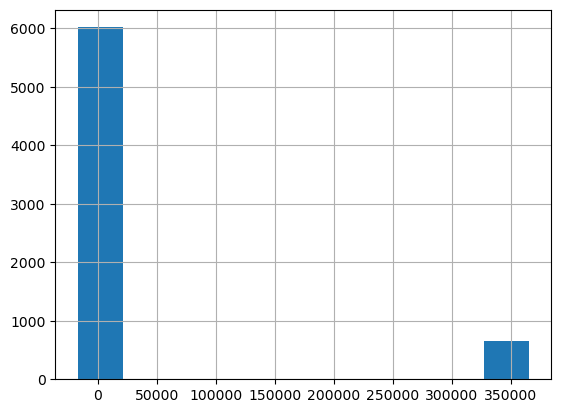

In [389]:
loan_accept['days_employed'].hist()

<AxesSubplot:>

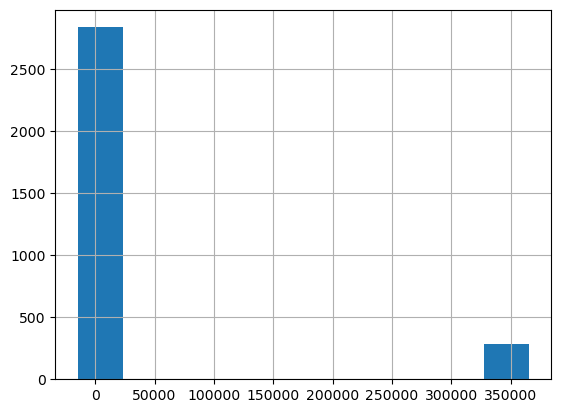

In [390]:
loan_reject['days_employed'].hist()

It seems as though the positive ones, are indeed the people that in the moment did not have employment, or also people that could be retired, lets see the distribution of the income type

In [391]:
loan_accept.loc[loan_accept['days_employed']>0,'income_type'].value_counts(normalize=True)

Pensioner    1.0
Name: income_type, dtype: float64

In [392]:
loan_reject.loc[loan_reject['days_employed']>0,'income_type'].value_counts(normalize=True)

Pensioner    1.0
Name: income_type, dtype: float64

Indeed all the pople that have a positive days_employed are pensioners, thus, for this cases, we will leave it as 100 years which will be in fact a huge number, that wil represent that these people will always have an stable income

In [393]:
#Converting the positive to 100 years

loan_accept.loc[loan_accept['days_employed']>0,'days_employed']=100
loan_reject.loc[loan_reject['days_employed']>0,'days_employed']=100

#Converting days_employed to years

loan_accept.loc[loan_accept['days_employed']<=0,'days_employed']=loan_accept.loc[loan_accept['days_employed']<=0,'days_employed']/-365
loan_reject.loc[loan_reject['days_employed']<=0,'days_employed']=loan_reject.loc[loan_reject['days_employed']<=0,'days_employed']/-365

#Rename the column
loan_accept = loan_accept.rename(columns={'days_employed': 'years_employed'})
loan_reject = loan_reject.rename(columns={'days_employed': 'years_employed'})

# Spliting into train test and validation

Now we will split first into train (60%), test(20%) and validation data(20%), but only for the accept dataset, further we will use the train data set to explore the data and see the behaviour of the target variable with the other variables. We will then compare several inference techniques that we will use in the methods to get the best result.

In [394]:
#Retriviving X and Y only from the accept one's
variables=[col for col in loan_accept.columns if col != 'Default']
X=loan_accept[variables]
y=loan_accept['Default']

In [395]:
#Split train, test and validation
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)

# Data exploration

For the data exploration we will visualize the relationships between the variables and 

In [396]:
#Distribution of the target variable

#Create labels
labels = ["Default - 0", "Default - 1"]

#Get the number per each of the default
values_train = np.bincount(train_labels)
values_test = np.bincount(test_labels)
values_val = np.bincount(val_labels)

#Create sublopt
fig = make_subplots(rows=1, cols=3,specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]])

fig.add_trace(go.Pie(title='Train',labels=labels, values=values_train,hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"]), row=1, col=1)
fig.add_trace(go.Pie(title='Test',labels=labels, values=values_test,hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"]), row=1, col=2)
fig.add_trace(go.Pie(title='Validation',labels=labels, values=values_val,hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"]), row=1, col=3)

fig.update_layout(title_text="Percentage of default in data sets")
fig.show()


We can see that the distribution of the target variable is indeed similar in all sets and is around 7% which is really low

In [397]:
#Create a df with the train data 
df_train = pd.concat([train_data, train_labels], axis=1)

In [398]:
# #Pairplot to visualize the relationships between continuous and binary variables
# sns.pairplot(df_train, hue='Default', diag_kind='kde')
# plt.show()

After going through the graph of the paiplot, we can see that there seems to be a direct or obvious relation within the variables excpet for number of children and number of members of the familiy, which indeed is obvious. Nevertheless, there seems to be a great relation between payment arreas and default. Indeed the variable payment_arreas denotes the number of days that the person has not payed the loan, thus at will be a cause of data lekeage, we will deleted from all the datasets.

*Note: The image of the plot if not displayed can be found on the folder as "pairplot" we recommend to open it in paint so the visualization is easier

In [399]:
df_train.columns

Index(['total_income', 'loan_amount', 'term', 'interest_rate', 'own_car',
       'own_house', 'nr_children', 'income_type', 'education_type',
       'family_status', 'housing_type', 'region_population_ratio',
       'years_birth', 'years_employed', 'years_registration', 'mobile_number',
       'phone_number', 'email', 'years_phone_change', 'occupation_type',
       'family_count', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'days_payment_arrears', 'Default'],
      dtype='object')

In [400]:
#Deleting payment_arreas as it will cause data lekeage while modeling
df_train=df_train.drop('days_payment_arrears',axis=1)
test_data=test_data.drop('days_payment_arrears',axis=1)
val_data=val_data.drop('days_payment_arrears',axis=1)

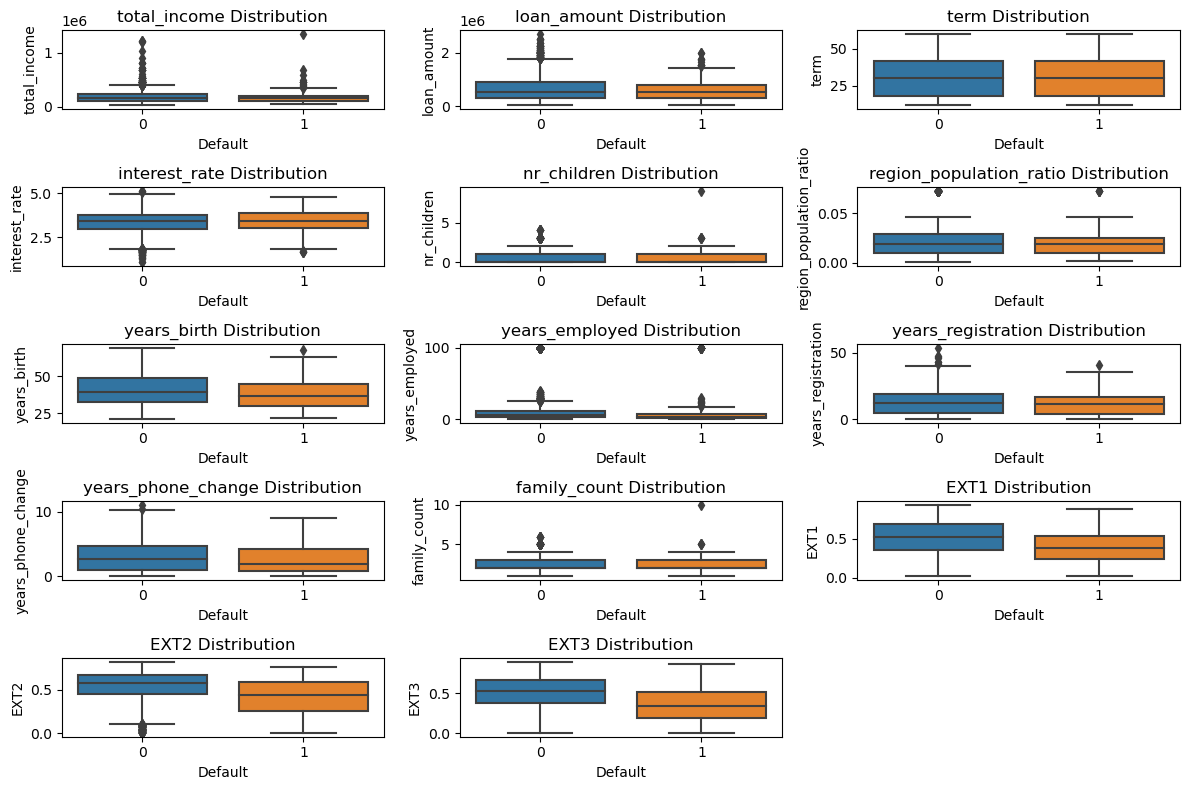

In [401]:
#Box plot to visualize the distribution of the numeric vairables only

#Create a list of only numeric types to get the binary and the numerical vairables
numeric_types=['int64','float64']

#Define numberic vairables
binary_var=['own_car','own_house','mobile_number','phone_number','email','EXT4','EXT5','EXT6','EXT7']
num_var=[col for col in df_train.select_dtypes(include=numeric_types).columns if (col not in binary_var and col!='Default')]

plt.figure(figsize=(12, 8))


for i, variable in enumerate(df_train[num_var]):
    plt.subplot(5,3, i + 1)
    sns.boxplot(x='Default', y=variable, data=df_train)
    plt.title(f'{variable} Distribution')
plt.tight_layout()
plt.show()

As seen on the graphs above, there are not evident relations between default, and the variables except for day payment arrears, which in fact the more days the more is the probability of default. We will keep an eye in this variable, since it could be its really realted to the target and could cause overfitting. On the other side, variables such as EXT1, EXT2 and EXT3 seem to have a negative correlation with the probability default. 

# Treating Outliers

In credit scoring data sets its always recommended to treat the outliers of the data set, since it could be possible that these points will eventually input bias to our model. We will first create boxplots, in order to see if there are some evident variables that need an outlier treatment

In [402]:
#See which variables have the same ranges
df_train[num_var].describe()

total_income   loan_amount         term  interest_rate  nr_children  \
count  4.003000e+03  4.003000e+03  4003.000000    4003.000000  4003.000000   
mean   1.796951e+05  6.563471e+05    31.879590       3.351504     0.518861   
std    9.679416e+04  4.203907e+05    15.746825       0.615311     0.781362   
min    2.700000e+04  4.500000e+04    12.000000       1.075623     0.000000   
25%    1.125000e+05  3.150000e+05    18.000000       2.987796     0.000000   
50%    1.575000e+05  5.450400e+05    30.000000       3.402015     0.000000   
75%    2.250000e+05  9.000000e+05    42.000000       3.774716     1.000000   
max    1.350000e+06  2.695500e+06    60.000000       5.125858     9.000000   

       region_population_ratio  years_birth  years_employed  \
count              4003.000000  4003.000000     4003.000000   
mean                  0.020971    40.901144       15.871913   
std                   0.014168    10.522696       28.627619   
min                   0.000533    21.175342        0.052055   
25%                   0.010006    32.268493        2.382192   
50%                   0.018801    39.315068        5.547945   
75%                   0.028663    48.343836       11.150685   
max                   0.072508    68.945205      100.000000   

       years_registration  years_phone_change  family_count         EXT1  \
count         4003.000000         4003.000000   4003.000000  4003.000000   
mean            12.589055            2.941215      2.283787     0.507640   
std              8.783861            2.316093      0.955483     0.208363   
min             -0.000000           -0.000000      1.000000     0.019207   
25%              4.938356            0.968493      2.000000     0.344351   
50%             11.756164            2.531507      2.000000     0.512654   
75%             18.719178            4.676712      3.000000     0.677379   
max             53.460274           11.049315     10.000000     0.938327   

              EXT2         EXT3  
count  4003.000000  4003.000000  
mean      0.531013     0.496427  
std       0.181393     0.196846  
min       0.000013     0.000527  
25%       0.433030     0.352340  
50%       0.576501     0.519097  
75%       0.669479     0.656158  
max       0.821394     0.887664

In [403]:
#Plot the first group
fig = go.Figure()

for col in ['total_income', 'loan_amount']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

In [404]:
#Plot the second group
fig = go.Figure()

for col in ['interest_rate', 'nr_children','family_count']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

There seems to be some outliers for these three variables, in order for our model to not be overfitted, we will indeed try to winsorized ths outliers.

In [405]:
#Plot the third group
fig = go.Figure()

for col in ['region_population_ratio', 'EXT1','EXT2','EXT3']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

There seems to be some outlier in EXT2, nevertheless there seems to be quite few points that fall below the "lower fence" of the boxplot, we will below plot the histogram of this graph to have a more clear view of the distribution of the variable. For the outlier in region_population_ratio, we will apply windsorization in order for a model to not be overfitted.

<AxesSubplot:>

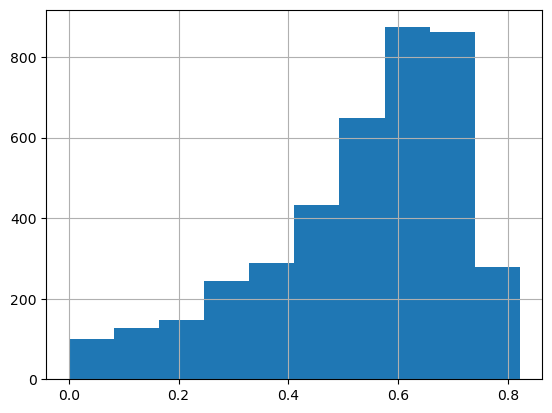

In [406]:
df_train['EXT2'].hist()

As we can see this variable seems to have an skewed distribution, and thus when plotting the boxplot, data seems to have several outliers, thus we will not treat this outliers

In [407]:
#Plot the fourth group
fig = go.Figure()

for col in ['years_birth','years_registration','years_phone_change','years_employed']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

We seem to have some outliers in the data, besides the 100 in the years_employed variable that we discusssed above. We will explain the process of treatment of these values below

In [408]:
#Plot the sixth group
fig = go.Figure()

fig.add_trace(go.Box(x=df_train['term'], name='term'))
fig.show()

This variable doesnt seem to have any apparent outliers

As discussed above, here is a summary of the outlier treatment that will be done:

-Windsorization:
    Family count
    Number of children
    Region population ratio

-Further analysis:
    years_phone_change
    years_registration
    years_birth
    years_employed

## Winsorization

We will use windsorizaiton for the variables above, since this method will help use preserve more the distribution of each of the data. If we had used Zscore it could be that the distribution of the data is not that well kept in the case of a non-normal distribution

For this case we will use 5% winsorization (2.5% for each tail), although familiy count and nr_children do not have outliers in the upper bound the winsorization will not affect the lower bound 

In [409]:
#Apply in dummy df to see the differences
cols = ["family_count", "nr_children","interest_rate"]

df_train_2=df_train.copy()
# 5% winsorization (2-sided -> 2.5% bottom, 97.5% top)
perc = 0.05

# winsorize column
df_train_2[cols] = df_train_2[cols].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))

C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\1757481232.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\1757481232.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\1757481232.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



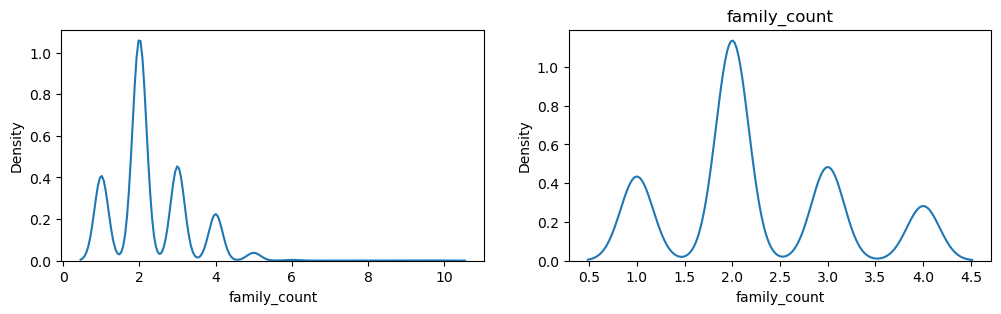

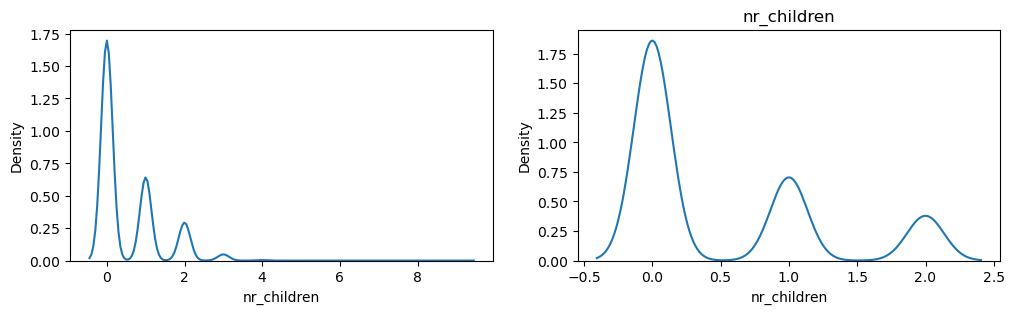

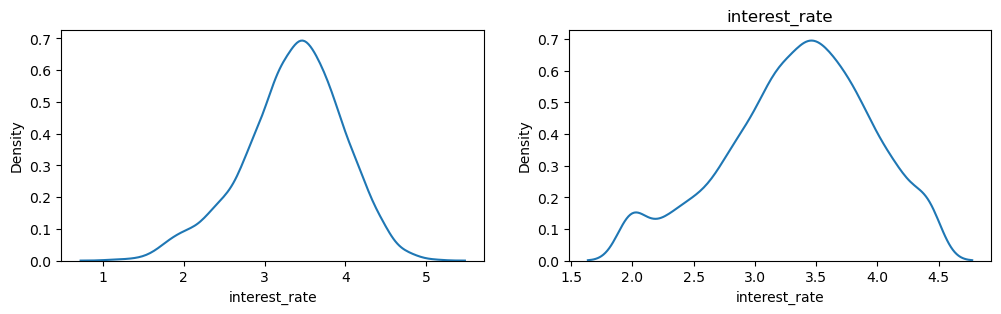

In [410]:
#Show the differences
for col in cols:
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    plt.title(col)
    sns.kdeplot(df_train[col], ax=ax[0])
    sns.kdeplot(data=df_train_2[col],ax=ax[1])
    fig.show()

As we can see indeed the winsorization helped us keep the distribution of the data, while removing the outliers. We will now apply it to the real data and will plot again the boxplot to see the results

In [411]:
#Applying to real data
df_train[cols] = df_train[cols].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))

In [412]:
#Applying to other datasets
for i in cols:
    max_val=np.max(df_train[i])
    min_val=np.min(df_train[i])
    
    loan_reject[i] = loan_reject[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))
    val_data[i] = val_data[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))
    test_data[i] = test_data[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))    

In [413]:
#Plot the second group
fig = go.Figure()

for col in ['interest_rate', 'nr_children','family_count']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

Indeed the outliers are now gone

## Further analysis

Indeed we still have to get rid of the outliers concerning years_phone_change, years_registration, years_employed. To treat this values, we will basically compare each one of them with the years_birth, if it suprasses this amount, we will put the age of the person instead. Then, we will do a boxplot analysis to see of there are any outliers left

In [414]:
#Process described above
for col in ['years_phone_change','years_registration']:
    #Getting number of cases
    cases=df_train[df_train[col]>df_train['years_birth']].shape[0]
    
    #print number of cases
    print("Cases in "+str(col)+" that are greater than years: "+str(cases))
    
    #Replace
    df_train.loc[df_train[col]>df_train['years_birth'],col]=df_train.loc[df_train[col]>df_train['years_birth'],'years_birth']

Cases in years_phone_change that are greater than years: 0
Cases in years_registration that are greater than years: 0


In [415]:
#Doing the same, but for years_employed

#Getting number of cases
cases=df_train[(df_train['years_employed']>df_train['years_birth'])&(df_train['years_employed']<100)].shape[0]

#print number of cases
print("Cases in years_employed that are greater than years: "+str(cases))

Cases in years_employed that are greater than years: 0


As seen above, there were no obervations with the case stated above. Thus, now we will just perform winsorization for the variables

In [416]:
#Apply in dummy df to see the differences
cols = ["years_phone_change", "years_registration"]

df_train_2=df_train.copy()
# 5% winsorization (2-sided -> 2.5% bottom, 97.5% top)
perc = 0.05

# winsorize column
df_train_2[cols] = df_train_2[cols].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))
df_train_2[df_train_2['years_employed']<100]=df_train_2[df_train_2['years_employed']<100].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))

C:\Users\fdiazgonzalezmanja\.conda\envs\ambiente1\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.



C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\3970773245.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\3970773245.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\fdiazgonzalezmanja\AppData\Local\Temp\ipykernel_4284\3970773245.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



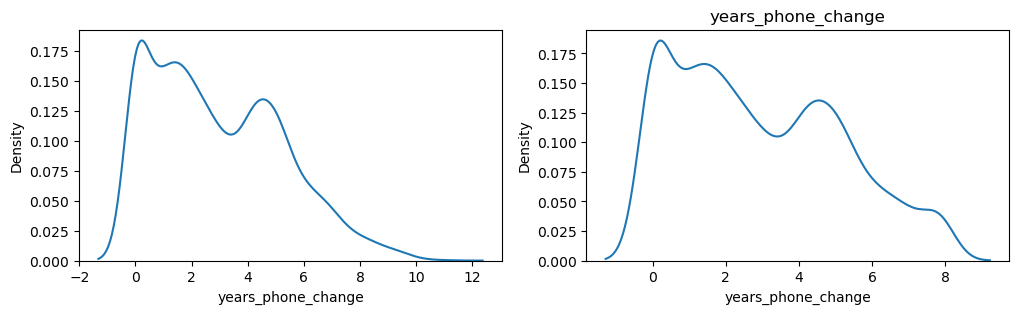

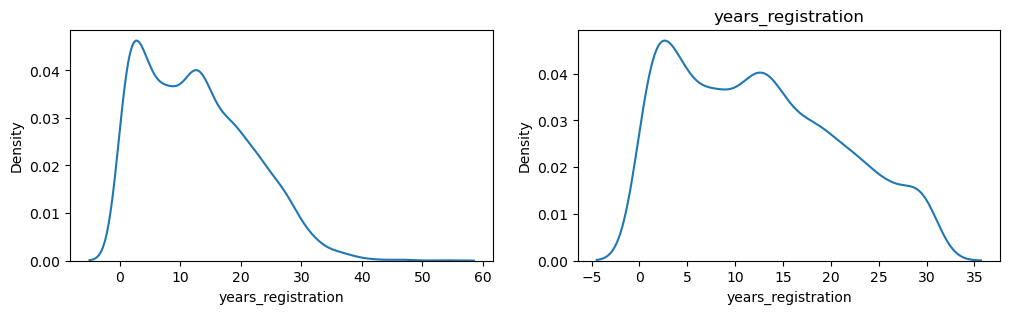

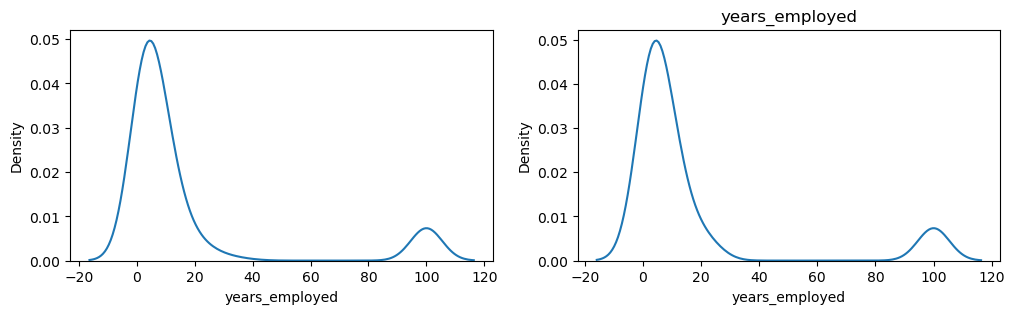

In [417]:
#Show the differences
for col in ["years_phone_change", "years_registration",'years_employed']:
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    plt.title(col)
    sns.kdeplot(df_train[col], ax=ax[0])
    sns.kdeplot(data=df_train_2[col],ax=ax[1])
    fig.show()

It seems the windsorization indeed worked out

In [418]:
#Apply to the real data
df_train[cols] = df_train[cols].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))
df_train[df_train['years_employed']<100]=df_train[df_train['years_employed']<100].apply(stats.mstats.winsorize, limits=(perc/2, perc/2))

C:\Users\fdiazgonzalezmanja\.conda\envs\ambiente1\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.



Here we apply the information to all the datasets, we make the exception for years employed

In [419]:
#Applying to other datasets
for i in cols:
    if i != 'years_employed':
        max_val=np.max(df_train[i])
        min_val=np.min(df_train[i])

        loan_reject[i] = loan_reject[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))
        val_data[i] = val_data[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))
        test_data[i] = test_data[i].apply(lambda y: max_val if y > max_val else (min_val if y < min_val else y))
    else:
        max_val=np.max(df_train.loc[df_train[i]!=100,i])
        min_val=np.min(df_train.loc[df_train[i]!=100,i])

        loan_reject[i] = loan_reject[i].apply(lambda y: y if y == 100 else (max_val if y > max_val else (min_val if y < min_val else y)))
        val_data[i] = val_data[i].apply(lambda y: y if y == 100 else (max_val if y > max_val else (min_val if y < min_val else y)))
        test_data[i] = test_data[i].apply(lambda y: y if y == 100 else (max_val if y > max_val else (min_val if y < min_val else y)))


In [420]:
#Plot the boxplot to see the results
#Plot the fourth group
fig = go.Figure()

for col in ['years_birth','years_registration','years_phone_change','years_employed']:
    fig.add_trace(go.Box(x=df_train[col], name=col))
fig.show()

# Weight of Evidence

We will now apply the weight of evidence for all the category variables, this is what will let us have the ranges for the credit scoring for the continuous variable , but also it will let us reduce the number of categories in the varaibles

In [421]:
#Go thorugh the categorical variables to see their number of categories and their distribution
cat_vars=train_data.select_dtypes(include=['object']).columns

fig = make_subplots(rows=3, cols=3,specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}],
                                           [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

for i,var in enumerate(cat_vars):
    
    cat_aux=pd.DataFrame()
    labels=train_data[var].value_counts().index
    values=train_data[var].value_counts(normalize=True).values
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.add_trace(go.Pie(title=var,labels=labels, values=values,hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"], showlegend=True), row=row, col=col)

fig.update_layout(title_text="Category variables and their distributions", showlegend=False)
fig.show()


As seen above there are some categories in education type, familiy status, housing type and occupation type that could be simplified, nevertheless, this will depend on the distribution with the target variable that they will have

In [422]:
#Create function to test WOE
def test_apply_woe(df,var,targ):
    #Get the number of current bins
    curr_var=df[var].nunique()
    
    #Initialize WOE
    var_woe = WOEEncoder(pred_var=var, target_var=targ)
    
    #Show df
    var_woe.test_limit(df)
    
    #Test WOE in income
    df_var=var_woe.test_limit(df)
    
    #Optimal stop limit according to greater IV and less stop limit
    stop_lim=df_var.sort_values(by='iv_total',ascending=False).head(1).values[0][0]
    
    #Get the information value
    inf_value=df_var.sort_values(by='iv_total',ascending=False).head(1).values[0][1]
    
    #Transform
    df=var_woe.fit_transform(df,stop_limit=stop_lim)
    
    #Create list
    res_list=[var_woe, curr_var, df_var, inf_value,df]
    
    return res_list

In the function above, we will test the WOE with different stop limits, these results all of the test will be returned in a df, nevertheless, the function will also take the samllest stop limit with the largest information value and will indeed transform the data

Now we will do a for loop over all the variables and will store as well the number of categories that were before, the current number of categories and the information value. Then we will print the summayr of the tests.

More below we will try to modify the number of bins created, to see if the interpretability of the credit score changes

In [423]:
#Create dictionary to store results
woe_test_dict = defaultdict(dict)

#Go thorugh the variables
for i in cat_vars:
    
    #Get the results
    woe_test_dict[i]=test_apply_woe(df_train,i,"Default")
    
    #Tranform df
    df_train[i]=woe_test_dict[i][4][i]

Fitted 5 bins for 'income_type' (levels=4)...
Fitted 4 bins for 'education_type' (levels=4)...
Fitted 4 bins for 'family_status' (levels=5)...
Fitted 6 bins for 'housing_type' (levels=10)...
Fitted 4 bins for 'occupation_type' (levels=19)...


We can see above the summary of the tranformation, familiy_status, stayed with the same amount, while income type got more bins, since, sometimes the woe function creates a "Missing" category, nevertheless the amount of categories on the data set is the same. In order to standarize the process we will leave it transformed. On the other hand, the categories of education_type, housing_type and occupation_type were reduced 

In [424]:
#Print the summary of the tests

for i in cat_vars:
    print("-"*30)
    print(i)
    print("-"*30)
    print(woe_test_dict[i][2])

------------------------------
income_type
------------------------------
   stop_limit  iv_total  n_bins
0       0.010  0.068087       3
1       0.025  0.068087       3
2       0.050  0.068087       3
3       0.100  0.068087       3
------------------------------
education_type
------------------------------
   stop_limit  iv_total  n_bins
0       0.010  0.035259       3
1       0.025  0.035259       3
2       0.050  0.035259       3
3       0.100  0.035259       3
------------------------------
family_status
------------------------------
   stop_limit  iv_total  n_bins
0       0.010  0.023948       3
1       0.025  0.023948       3
2       0.050  0.023948       3
3       0.100  0.023948       3
------------------------------
housing_type
------------------------------
   stop_limit  iv_total  n_bins
0       0.010  0.140193       6
1       0.025  0.134556       4
2       0.050  0.128801       3
3       0.100  0.128801       3
------------------------------
occupation_type
-----------

We will take into account the sumamry above, when trying different number of bins for the scorecard

## Apply WOE in rejected, validation and test

We will now apply the same WOE to the reject set, validation set and test set. We will first go thorugh all the categories, and see if there is a category that is not in the fit_dictionary of the WOE. Then we will try to allocate this categories accordingly, either on the missing columns we created above, or try to see if they are similar to existing ones

In [425]:
#Go through each of the variables and see which ones are not in the dictionary of the WOE

#Create dictionary to go thorugh all the three datasets
sets_temp = {
    "reject":loan_reject,
    "validation":val_data,
    "test":test_data
}

for set_nom in sets_temp.keys():
    set_temp=sets_temp[set_nom]
    for i in cat_vars:
        for j in set_temp[i].unique():
            if j not in woe_test_dict[i][0].fit_dict.keys():
                print("Value: "+str(j)+" from the varible: "+ str(i) + " is not in the dictionary" + " Data set: "+str(set_nom))

Value: Academic degree from the varible: education_type is not in the dictionary Data set: reject
Value: Student from the varible: income_type is not in the dictionary Data set: validation
Value: Academic degree from the varible: education_type is not in the dictionary Data set: validation
Value: Academic degree from the varible: education_type is not in the dictionary Data set: test


As we can see there are two categories that were not seen before: "Academic degree" and "Student". For the first one we will considred as "Higher Education", and for the second one, we will allocate the student in the missing column of 'income_type'

In [426]:
#Replace Academic degree as Higher education
loan_reject.loc[loan_reject['education_type']=='Academic degree','education_type']='Higher education'
val_data.loc[val_data['education_type']=='Academic degree','education_type']='Higher education'
test_data.loc[test_data['education_type']=='Academic degree','education_type']='Higher education'

In [427]:
#Transform income_type for student
val_data['income_type'] = val_data['income_type'].apply(lambda y: woe_test_dict['income_type'][0].fit_dict[y] if y != 'Student' else 'income_type_missing')

In [428]:
#Transform data applying the same WOE used, except for income_type

for var in cat_vars:
    
    if var!='income_type':
        loan_reject=woe_test_dict[var][0].transform(loan_reject)
        val_data=woe_test_dict[var][0].transform(val_data)
        test_data=woe_test_dict[var][0].transform(test_data)
    else:
        loan_reject=woe_test_dict[var][0].transform(loan_reject)
        test_data=woe_test_dict[var][0].transform(test_data)


# Dummy variables

We will now convert the categorical variables into dummy variables, moreover, we can see that only occupation_type has a missing category. Thus, we will add another column with 0's in it for the rest of the variables, since possibly we will encounter categorical values that are not in our train set

In [429]:
df_train_2=df_train.copy()

In [430]:
df_train_2=pd.get_dummies(df_train_2, drop_first=False, prefix='', prefix_sep='')

In [431]:
df_train_2.columns

Index(['total_income', 'loan_amount', 'term', 'interest_rate', 'own_car',
       'own_house', 'nr_children', 'region_population_ratio', 'years_birth',
       'years_employed', 'years_registration', 'mobile_number', 'phone_number',
       'email', 'years_phone_change', 'family_count', 'EXT1', 'EXT2', 'EXT3',
       'EXT4', 'EXT5', 'EXT6', 'EXT7', 'Default', 'income_type_1',
       'income_type_2', 'income_type_5', 'education_type_1',
       'education_type_2', 'education_type_4', 'family_status_1',
       'family_status_2', 'family_status_4', 'housing_type_1',
       'housing_type_2', 'housing_type_3', 'housing_type_4', 'housing_type_5',
       'housing_type_6', 'occupation_type_1', 'occupation_type_2',
       'occupation_type_3', 'occupation_type_4'],
      dtype='object')

In [432]:
#Convert all categorical variables to dummies

df_train = pd.get_dummies(df_train, drop_first=False, prefix='', prefix_sep='')
loan_reject=pd.get_dummies(loan_reject, drop_first=False, prefix='', prefix_sep='')
val_data=pd.get_dummies(val_data, drop_first=False, prefix='', prefix_sep='')
test_data=pd.get_dummies(test_data, drop_first=False, prefix='', prefix_sep='')

In [433]:
#Create missing columns for categorical variables, except for occupation_type

for var in cat_vars:
    if var!='occupation_type':
        df_train[str(var)+"_missing"]=np.zeros(df_train.shape[0])
        loan_reject[str(var)+"_missing"]=np.zeros(loan_reject.shape[0])
        test_data[str(var)+"_missing"]=np.zeros(test_data.shape[0])
        if var!= 'income_type':
            val_data[str(var)+"_missing"]=np.zeros(val_data.shape[0])            

In [434]:
#Edit train_data and train_labels
var_cols=[col for col in df_train.columns if col!='Default']
train_labels=df_train['Default']
train_data=df_train[var_cols]

In [435]:
#Reorder the columns in dataset so they have the same order

#Get the column order from 'train_data'
column_order = train_data.columns

#Reorder columns in 'loan_reject'
loan_reject = loan_reject[column_order]

#Reorder columns in 'test_data'
test_data = test_data[column_order]

#Reorder columns in 'val_data'
val_data = val_data[column_order]

# Reject Inference techniques & Modelling

For the data modeling, we will try three reject inference techniques (reject = Default, Probability cut off, Predictive approach) to combine the reject dataset with the accept dataset. After that, for each of these techniques we will create three datasets (normal, oversampling and undersampling) for the train set (accept+reject). Finally we will create models for each of these that will be trained to minimize the total cost of each of the train sets respectively and we will choose the model with the lowest cost on the test set.

In [436]:
#Create dictionary where we will store the first versions of the train sets (accept + reject) of each method
train_dict = defaultdict(dict)

## Reject = Default

This method implies that all the rejected people should be considered as Default in this case 0

In [437]:
#First we define all the reject ones as 1
X_1 = pd.concat([train_data, loan_reject], axis=0).reset_index(drop=True)
y_1 = np.append(train_labels, np.ones(loan_reject.shape[0]))

In [438]:
#We create a temporary dictionary,with the data that we just merged and the validation set
data_reject_default = {
    "X_train":X_1,
    "y_train":y_1,
    "X_valid":val_data,
    "y_valid":val_labels,
}

#Now we store this data in the dictionary of the train sets
train_dict['All_default']=data_reject_default

## Probability cutoff

We will now apply the probability cutoff approach for the default. First we will fit a model, to the train_data to get a model that will give us a probability for the reject one to default. Then we will sort these probabilities and we will see the probability of the 15% of the observations. This probability will be our cutoff value, which means that any observation below that probability will be considered as 0 ('non default') and the rest will be considered 1 ('default'). The 15% is an arbitrary bound but this help us get the observations on the reject data set that have the lowest probability of being rejected. 

We will do first train the model only with the training set and see the results with the validation set. Then we will use this model to get the probabilities of default on the reject data set

In [439]:
#Setup Grid search for logistic regression model
logistic = LogisticRegression()

models = {"logistic":logistic}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300],
                    "class_weight": ["balanced"]
                }
            }

In [440]:
# Define functions for evaluation metric
def eval_metrics(proba, true):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.round(proba) # convert proba to binary labels

    auc = roc_auc_score(true, proba)
    f1 = f1_score(true, pred)

    return {
        'AUC': auc,
        'F1': f1,
    }

In [441]:
#Define function to go through the gridsearch and get the evaluation metrics for the validation set as well as to get the matrix
def run_GridSearch(name, data, model, param_grid, **kwargs):
    # save results
    metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(data["X_train"], data["y_train"])
    
    # predict
    proba_train   = gs.predict_proba(data["X_train"])[:,1]
    proba_valid   = gs.predict_proba(data["X_valid"])[:,1]

    # evaluate
    metrics[name]["train"] = eval_metrics(proba_train,data["y_train"])
    metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
        for key, val in metrics[name].items():
            print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(data["y_valid"], np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs, metrics

In [442]:
# original data
data_temp = {
    "X_train":train_data,
    "y_train":train_labels,
    "X_valid":val_data,
    "y_valid":val_labels,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

logistic: {'C': 0.25, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.7953	F1: 0.2838
valid:  AUC: 0.7585	F1: 0.2534
          pred:no  pred:yes
true:no       880       355
true:yes       34        66


In [443]:
# Refit selected model and save it
model2 = LogisticRegression(**model_dict["logistic"].best_params_)
model2.fit(train_data, train_labels)

LogisticRegression(C=0.25, class_weight='balanced', max_iter=300, penalty='l1',
                   solver='liblinear')

Now we will plot the probabilities of the train and the reject set

In [444]:
# get probabilities
pred_train = pd.DataFrame(model2.predict_proba(train_data))[1]
pred_reject = pd.DataFrame(model2.predict_proba(loan_reject))[1]

# display probability distribution
fig = go.Figure()
fig.add_trace(go.Histogram(x=pred_train, name='train'))
fig.add_trace(go.Histogram(x=pred_reject, name='reject'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.7)
fig.show()

As we can see most of the observations have a probability of 0.2, in fact the distribution of the probability of default in the train set is quite similar to the one on the reject set. This could denote that in fact there could be a possiblity that historic data was biased by another factor, other that ones in the dataset

We will now calculate the probability cut off as stated above and as a result we will have the categorization for the default dataset

In [445]:
# Label rejects based on cutoff

# Define 15% cutoff
cutoff_15 = int(len(pred_reject) * 0.15)

# Compute cutoff value
cutoff_value = np.max(np.sort(pred_reject)[:cutoff_15])
print("Cutoff probability: {:.3f}%".format(cutoff_value*100))

# Assign "Default" value to rejected loan applicants
y_reject = np.array(pred_reject > cutoff_value, dtype=int)

Cutoff probability: 17.118%


As seen above the probability is 17% so every observation in the reject data set above this number will be considered as default, and viceversa. Indeed the 85% cutoff is quite strict. We will create a new data set incorporating the results of the default and will create another model that will be trained with the train and default data. The result in these last set and in the validation of this last model, will be compared to the other methods

In [446]:
# Incorporate labelled rejects with accepts and save it in the train set dictionary

X_2 = pd.concat([train_data, loan_reject], axis=0).reset_index(drop=True)
y_2 = np.append(train_labels, y_reject)

data_cutoff = {
    "X_train":X_2,
    "y_train":y_2,
    "X_valid":val_data,
    "y_valid":val_labels,
}

train_dict['Cutoff']=data_cutoff

## Predictive Approach

The predictive approach is basically the same method as the probability cutoff, just that we remove the cutoff probability and simply the observations in the default set that are greater than 0.5 are considered defaults and viceversa

Below we create the new data set and we use the function round to the probability we computed above, to achieve the desired result

In [447]:
# Incorporate labelled rejects with accepts and add it to the dictionary of the train sets 

X_3 = pd.concat([train_data, loan_reject], axis=0).reset_index(drop=True)
y_3 = np.append(train_labels, np.round(pred_reject))

data_proba = {
    "X_train":X_3,
    "y_train":y_3,
    "X_valid":val_data,
    "y_valid":val_labels,
}

train_dict['Proba']=data_proba

# Over and undersampling

We will now go through the three train sets and aply and over and undersampling method to create the three train sets for each of them

In [448]:
train_list=train_dict.copy().keys()

In [449]:
for i in train_list:
        
    #Extract the original train sets of the method 
    X_train=train_dict[i]['X_train']
    y_train=train_dict[i]['y_train']

    #Create oversampling
    sample_over = SMOTE(random_state=42)
    X_train_over, y_train_over = sample_over.fit_resample(X_train, y_train)
    
    #Create dictionary with oversampling
    data_over = {
        "X_train":X_train_over,
        "y_train":y_train_over,
        "X_valid":val_data,
        "y_valid":val_labels}
    
    #Save dictionary
    train_dict[str(i)+'_over']=data_over
    

    #Create undersampling
    sample_under = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = sample_under.fit_resample(X_train, y_train)
    
    #Create dictionary with oversampling
    data_under = {
        "X_train":X_train_under,
        "y_train":y_train_under,
        "X_valid":val_data,
        "y_valid":val_labels}
    
    #Save dictionary
    train_dict[str(i)+'_under']=data_under

# Compute total cost

As the company is looking for a model that minimizes risk and associated costs, we will now compute the total cost for each of the observations. In this case the total cost will be calculated with the false positive cost and the false negative cost. These costs will be calculated with the loss given default and the risk-free interest rate that the company has priveded us (75% and 1.5% resepectively). We will first calcualte the cost for all the observations and then we will compute the optimal threshold that minimizes the totla cost on the train set. This optimized threshold will serve as a basis to calculate the cost in the test set, which will be the decisive factor in choosing the model.

We will first define the functions that will help us compute cost of false positive and the cost of false negative

In [450]:
# Annuity
def A(am, ir_c, n):
    return am * (ir_c*(1+ir_c)**n) / ((1+ir_c)**n - 1)

# Present Value
def PV(A, ir_rf, n):
    return A * (1-1/((1+ir_rf)**n)) / ir_rf

# Future Value
def FV(am, ir, n):
    return am * (1+ir)**n

In [451]:
def cost_FP(am, n, ir_c, ir_rf=0.015):
    return PV(A(am,ir_c,n),ir_rf,n) - am

def cost_FN(am, lgd=0.75):
    return am*lgd

In [452]:
def total_cost(true, pred, cTP, cFN, cFP, cTN):
    return true*(pred*cTP+(1-pred)*cFN)+(1-true)*(pred*cFP+(1-pred)*cTN)

Below we will calculate the cost for each of the train sets and we will store it in a new dictionary

In [453]:

for i in train_dict.keys():
    
    #Get the train dataset
    X_train=train_dict[i]['X_train']
    
    #Create the data set with the costs
    cm_train = pd.DataFrame()
    cm_train["cFP"] = cost_FP(X_train["loan_amount"], X_train["term"]/12, X_train["interest_rate"]/100)
    cm_train["cFN"] = cost_FN(X_train["loan_amount"])
    cm_train["cTP"] = 0.0
    cm_train["cTN"] = 0.0
    
    #Store it in the same dictionary
    train_dict[i]['cm_train']=cm_train

We will now create the cost for the validation and the tests sets which will be the same for all the data sets

In [454]:
#Costs for validation set
cm_valid = pd.DataFrame()
cm_valid["cFP"] = cost_FP(val_data["loan_amount"], val_data["term"]/12, val_data["interest_rate"]/100)
cm_valid["cFN"] = cost_FN(val_data["loan_amount"])
cm_valid["cTP"] = 0.0
cm_valid["cTN"] = 0.0

#Cost for test set
cm_test = pd.DataFrame()
cm_test["cFP"] = cost_FP(test_data["loan_amount"], test_data["term"]/12, test_data["interest_rate"]/100)
cm_test["cFN"] = cost_FN(test_data["loan_amount"])
cm_test["cTP"] = 0.0
cm_test["cTN"] = 0.0

In [455]:
#We will store as well the cm_valid in each of the data sets
for i in train_dict.keys():
    train_dict[i]['cm_valid']=cm_valid

We will now train a logistic model for each of the train sets to get the probability of default, below we define the model, and the hyperparamter tuning process as well as the evaluation metrics function that we will use to fit the model

In [456]:
#Setup Grid search for logistic regression model
logistic = LogisticRegression(random_state=42)

models = {"logistic":logistic}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300],
                    "class_weight": ["balanced"] # can be extended to custom class weights
                }
            }

In [457]:
# evaluation metrics
def eval_metrics(proba, true, cm, t=0.5):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.array(proba > t, dtype=int) # probability threshold

    auc = roc_auc_score(true, proba)
    f1 = f1_score(true, pred)
    cost = np.sum(total_cost(true, pred, **cm))

    return {
        'AUC': auc,
        'F1': f1,
        "Cost": cost,
    }

In [458]:
def run_GridSearch(name, data, model, param_grid, **kwargs):
#     # save results
#     metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(data["X_train"], data["y_train"])
    
    # predict
    proba_train   = gs.predict_proba(data["X_train"])[:,1]
    proba_valid   = gs.predict_proba(data["X_valid"])[:,1]

#     # evaluate
#     metrics[name]["train"] = eval_metrics(proba_train,data["y_train"],data["cm_train"])
#     metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"],data["cm_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
#         for key, val in metrics[name].items():
#             print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(data["y_valid"], np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs#, metrics

In [459]:
def tune_threshold(true, proba, cm):
    thresholds = np.arange(0, 1, 0.001)
    costs = [np.sum(total_cost(true, np.array(proba > t, dtype=int), **cm)) for t in thresholds]
    return thresholds, costs

In [464]:
#Create model dictionary to store the results of each of the models
model_dict = defaultdict(dict)
eval_dict = defaultdict(dict)
thresh_dict=defaultdict(dict)

for i in train_dict.keys():
    
    #Create default dictionary
    metric_dict = defaultdict(dict)
    
    #Get the train data
    data_temp=train_dict[i]

    #loop through models in models dictionary
    for name, model in models.items():
        #Train model
        print('-'*20)
        print("Training... "+str(i))
        
        model_dict[str(i)+'_'+str(name)] = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], print=False)
        print("Model "+str(i)+" has benn trained")
        print('-'*20)
        
        #Get the threshold that the cost for each value of the threshold
        thresholds, costs = tune_threshold(data_temp['y_train'], model_dict[str(i)+'_'+str(name)].predict_proba(data_temp['X_train'])[:,1], data_temp['cm_train'])
        
        #Save performance on train,valid and test set
        metric_dict[name]['train']=eval_metrics(model_dict[str(i)+'_'+str(name)].predict_proba(data_temp['X_train'])[:,1], data_temp['y_train'], data_temp['cm_train'], t=thresholds[np.argmin(costs)])
        metric_dict[name]['valid']=eval_metrics(model_dict[str(i)+'_'+str(name)].predict_proba(val_data)[:,1], val_labels, cm_valid, t=thresholds[np.argmin(costs)])
        metric_dict[name]['test']=eval_metrics(model_dict[str(i)+'_'+str(name)].predict_proba(test_data)[:,1], test_labels, cm_test, t=thresholds[np.argmin(costs)])
    
        #Save the results on evaluation dictionary
        eval_dict[str(i)+"_"+str(name)]=metric_dict[name]
        
        #Save threshold for each model
        thresh_dict[i]=[thresholds,costs,thresholds[np.argmin(costs)]]

--------------------
Training... All_default
Model All_default has benn trained
--------------------
--------------------
Training... Cutoff
Model Cutoff has benn trained
--------------------
--------------------
Training... Proba
Model Proba has benn trained
--------------------
--------------------
Training... All_default_over
Model All_default_over has benn trained
--------------------
--------------------
Training... All_default_under
Model All_default_under has benn trained
--------------------
--------------------
Training... Cutoff_over
Model Cutoff_over has benn trained
--------------------
--------------------
Training... Cutoff_under
Model Cutoff_under has benn trained
--------------------
--------------------
Training... Proba_over
Model Proba_over has benn trained
--------------------
--------------------
Training... Proba_under
Model Proba_under has benn trained
--------------------


## Comparison of the three models

In [466]:
# Display full overview
overview = pd.DataFrame(pd.concat({k: pd.DataFrame(v) for k,v in eval_dict.items()}, axis=1)).T

# convert cost to million
overview["Cost"]=round(overview["Cost"] / 1_000_000,2)

overview

AUC        F1   Cost
All_default_logistic       train  0.600389  0.649048  79.74
                           valid  0.714453  0.139373  26.83
                           test   0.699966  0.125000  26.28
Cutoff_logistic            train  0.700912  0.636884  74.14
                           valid  0.747457  0.153605  25.92
                           test   0.720625  0.138978  23.91
Proba_logistic             train  0.905684  0.668452  62.40
                           valid  0.759304  0.242215  20.67
                           test   0.721870  0.208696  22.74
All_default_over_logistic  train  0.629786  0.666667  79.74
                           valid  0.710040  0.139373  26.83
                           test   0.697657  0.125000  26.28
All_default_under_logistic train  0.601253  0.666667  74.20
                           valid  0.710834  0.139373  26.83
                           test   0.695980  0.125000  26.28
Cutoff_over_logistic       train  0.784795  0.707110  76.19
                           valid  0.741360  0.152660  24.98
                           test   0.714701  0.135647  24.81
Cutoff_under_logistic      train  0.702391  0.706713  54.25
                           valid  0.749870  0.151585  26.29
                           test   0.721392  0.136900  24.38
Proba_over_logistic        train  0.973109  0.854779  69.34
                           valid  0.756186  0.225806  20.29
                           test   0.714601  0.185239  23.72
Proba_under_logistic       train  0.901261  0.733027  25.12
                           valid  0.760615  0.173524  22.33
                           test   0.719886  0.151246  23.01

In [467]:
#Filter only the test column and sort by the cost
overview.iloc[overview.index.get_level_values(1) == "test",:].sort_values("Cost", ascending=True)

AUC        F1   Cost
Proba_logistic             test  0.721870  0.208696  22.74
Proba_under_logistic       test  0.719886  0.151246  23.01
Proba_over_logistic        test  0.714601  0.185239  23.72
Cutoff_logistic            test  0.720625  0.138978  23.91
Cutoff_under_logistic      test  0.721392  0.136900  24.38
Cutoff_over_logistic       test  0.714701  0.135647  24.81
All_default_logistic       test  0.699966  0.125000  26.28
All_default_over_logistic  test  0.697657  0.125000  26.28
All_default_under_logistic test  0.695980  0.125000  26.28

As we can see the method that gave better results was the probability method which although it was overfitted on the train set, had good and similar results on the test and validation. Moreover, although it did not have the best AUC, indeed it had the best F1 score and the less cost

The graph below shows the threshold probability that minimizes the cost for the best model, and that should be used to decide if a customer is going to default or not

In [475]:
#best threshold for the best model
thresh_bmodel=thresh_dict['Proba'][2]
print("Best threshold: ",thresh_bmodel)

Best threshold:  0.401


In [486]:
# Plot cost for all cutoffs
thresholds=thresh_dict['Proba'][0]
costs=thresh_dict['Proba'][1]

fig = go.Figure(data=go.Scatter(x=thresholds, y=costs, mode='lines+markers'))
fig.add_hline(y=np.min(costs), line_dash="dot", line_color="black")
fig.add_vline(x=thresholds[np.argmin(costs)], line_dash="dot", line_color="black")
fig.update_layout(
    title="Logistic Regression with probability and normal dataset",
    xaxis_title="Threshold",
    yaxis_title="Cost"
)
fig.show()

# Coefficients

After having selected the best model, now we will see the impact of the variables, and will see the weight of each of the variables, although we will only display the coefficients and the impact of the variables on the model still depend on the scale of each of the variables, it can give us an idea of the positive/negative impact that each of the variables can have when granting a loan.

First we will refit again the model that we selected above

In [490]:
#Refit selected model
best_model = LogisticRegression(**model_dict["Proba_logistic"].best_params_)
best_model.fit(train_dict['Proba']['X_train'],train_dict['Proba']['y_train'] )

LogisticRegression(C=0.5, class_weight='balanced', max_iter=200, penalty='l1',
                   solver='liblinear')

Now we will display the coefficientes of the model, in order to see the coefficients of the model, please use the zoom tool

In [522]:
# Display Model Coefficients
fig = go.Figure([
    go.Bar(y=train_dict['Proba']['X_train'].columns, x=best_model.coef_[0], text=np.round(best_model.coef_[0], 2), orientation='h')
    ])

fig.update_traces(textposition='outside', marker_color='rgb(0, 92, 153)')
fig.update_layout(title='Logistic Regression Coefficients',
                  dragmode='select',
                  width=900,
                  height=1500,
                  hovermode='closest')
fig.show()

As we can see in the graph, there are some varaibles that actually have next to none impact on the model. Nevertheless, some of them actually do not have information, but we will leave the columns to in the future the model can be retrained

# Scores

We will now, get the score of each of the observations with the model that we chose above. For this we will use the following function, that will take the logit (the value of the variable times the coefficient of the variable in the model, and we will take the number of observations in the model and finally get the intercept for the model. All this process will only be computed for the test set.

In [542]:
def score_func(logit, params, intercept, target=850, target_odds=200, pdo=20):
    """
    Data-driven application scoring function.
    Inspired by: https://blogs.sas.com/content/subconsciousmusings/2019/01/18/building-credit-scorecards-using-statistical-methods-and-business-logic/
    """
    
    factor = pdo / np.log(2)
    offset = target - factor * np.log(target_odds)

    # regression model predicts default, therefore: factor*logit is deducted from offset
    score  = offset/params + factor * (logit + intercept/params)
    
    return score

Here we will now compute the scores for each of the observations

In [543]:
# get model intercept
ic = best_model.intercept_.item()

# compute log odds (coef * value)
df_logit = test_data * best_model.coef_

# compute score for all applicants
df_score = score_func(df_logit, df_logit.shape[1], ic)

# compute row sums (total score per applicant) and sort values
sum_sort = np.sort(np.sum(df_score, axis=1))

We will now create a graph to see the accumulative distribution of the scores

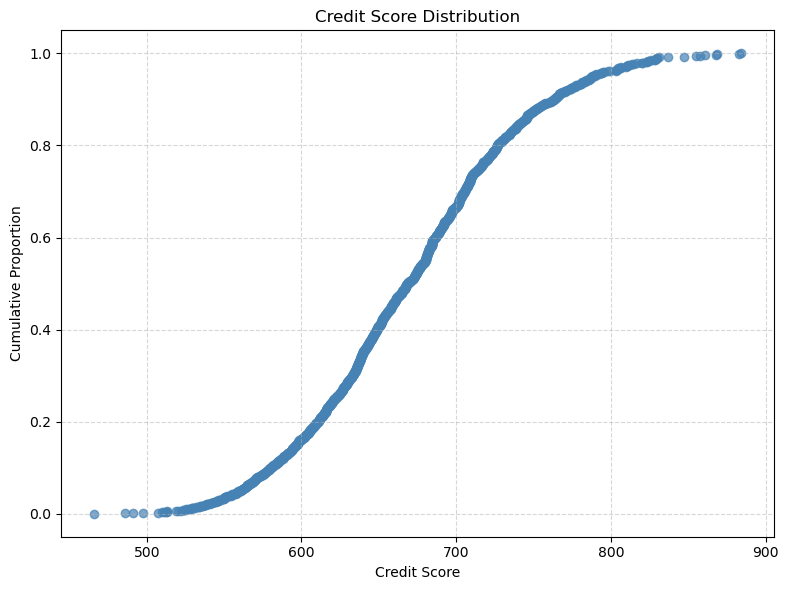

In [544]:
#Plot the relative cumulative score
cumulative_sum = np.cumsum(sum_sort)
total_sum = sum(sum_sort)
cumulative_proportion = cumulative_sum / total_sum

plt.figure(figsize=(8, 6))
plt.scatter(sum_sort, cumulative_proportion, color='steelblue', alpha=0.7)
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Cumulative Proportion")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Scorecard evaluation

We will now compute the scorecard evaluation for the scores computed above

First to start with this step we will get the results of the test set according to the threshold that we selected before

In [545]:
def get_results(proba, true, t=0.5):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.array(proba > t, dtype=int)
    return pred

In [546]:
test_results=get_results(best_model.predict_proba(test_data)[:,1], test_labels, t=thresh_bmodel)

Now we wil create the table in which we will display the ranges of scores and their acceptance and the rejection rate, we chose to displahy the ranges in multiples of 25 since it is easier like that to read the final table

In [547]:
#Define the step of the ranges
r_step=25

#Get the min score
min_score=np.ceil(np.min(np.sum(df_score, axis=1))/r_step)*r_step

#Get the max score
max_score=np.floor(np.max(np.sum(df_score, axis=1))/r_step)*r_step

In [548]:
def get_prop(array):
    #Calculate the count of 0's and 1's
    count_zeros = sum(1 for elem in array if elem == 0)
    count_ones = sum(1 for elem in array if elem == 1)

    #Calculate the fraction of 0's and 1's
    total_elements = len(array)
    
    if total_elements == 0:
        fraction_zeros = 0
        fraction_ones = 0
    else:
        fraction_zeros = count_zeros / total_elements
        fraction_ones = count_ones / total_elements

    return count_zeros, count_ones, fraction_zeros, fraction_ones

In [549]:
lower_bound=[]
upper_bound=[]
num_accept=[]
num_reject=[]
acc_rate=[]
rej_rate=[]
tot_score=np.sum(df_score, axis=1)
for i in np.arange(min_score, max_score+r_step+1, r_step):
    lower_bound.append(i-r_step)
    upper_bound.append(i)
    res=get_prop(test_results[(tot_score<i)&(tot_score>=(i-r_step))])
    num_accept.append(res[0])
    num_reject.append(res[1])
    acc_rate.append(res[2])
    rej_rate.append(res[3])

In [550]:
ev_score = {
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,
    'Number of Accepts': num_accept,
    'Number of Rejects': num_reject,
    'Acceptance Rate': np.round(acc_rate,2),
    'Rejection Rate': np.round(rej_rate,2)
}

df_ev_score = pd.DataFrame(ev_score)

In [551]:
df_ev_score

Lower Bound  Upper Bound  Number of Accepts  Number of Rejects  \
0         450.0        475.0                  1                  0   
1         475.0        500.0                  3                  0   
2         500.0        525.0                 12                  0   
3         525.0        550.0                 40                  0   
4         550.0        575.0                 80                  0   
5         575.0        600.0                117                  0   
6         600.0        625.0                145                  0   
7         625.0        650.0                201                  0   
8         650.0        675.0                160                  0   
9         675.0        700.0                 90                 90   
10        700.0        725.0                  0                152   
11        725.0        750.0                  0                103   
12        750.0        775.0                  0                 59   
13        775.0        800.0                  0                 41   
14        800.0        825.0                  0                 24   
15        825.0        850.0                  0                 10   
16        850.0        875.0                  0                  5   
17        875.0        900.0                  0                  2   

    Acceptance Rate  Rejection Rate  
0               1.0             0.0  
1               1.0             0.0  
2               1.0             0.0  
3               1.0             0.0  
4               1.0             0.0  
5               1.0             0.0  
6               1.0             0.0  
7               1.0             0.0  
8               1.0             0.0  
9               0.5             0.5  
10              0.0             1.0  
11              0.0             1.0  
12              0.0             1.0  
13              0.0             1.0  
14              0.0             1.0  
15              0.0             1.0  
16              0.0             1.0  
17              0.0             1.0

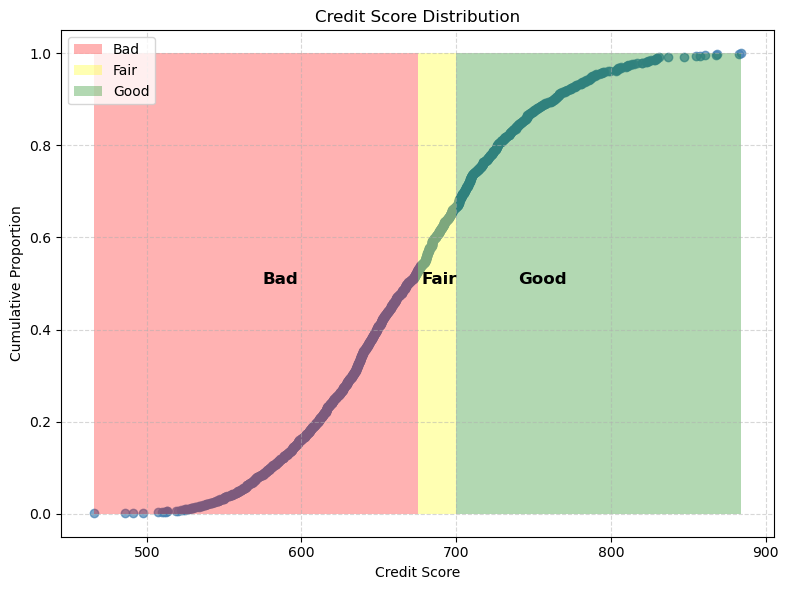

In [552]:
#Display the graph of the distribution and the respective classification
range_color = [675, 700]
plt.figure(figsize=(8, 6))
plt.scatter(sum_sort, cumulative_proportion, color='steelblue', alpha=0.7)

plt.fill_between([min(sum_sort), range_color[0]], 0, 1, facecolor='red', alpha=0.3, label='Bad')
plt.fill_between([range_color[0], range_color[1]], 0, 1, facecolor='yellow', alpha=0.3, label='Fair')
plt.fill_between([range_color[1], max(sum_sort)], 0, 1, facecolor='green', alpha=0.3, label='Good')


plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Cumulative Proportion")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.text(range_color[0] - 100, 0.5, 'Bad', fontsize=12, color='black', fontweight='bold')
plt.text((range_color[0] + range_color[1]+20) / 2 - 20, 0.5, 'Fair', fontsize=12, color='black', fontweight='bold')
plt.text(range_color[1] + 40, 0.5, 'Good', fontsize=12, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In this section we went back and forth with computing the scores and evaluating the scores. In evaluating the cosres we plot the ranges in multiples of 25 (since it is a good interpretable number), and for each of these ranges we calculated the acceptance rate and the rejection rate. After analyzing the table, we tried to tune the PDO and the target_odds parameter to get a score distribution that could be easily read by our team and that we could also easily explain to our customers. Indeed, the credit policy of the company will be quite more conservative since the objective of the company is to minimize the cost, thus in order to minimize the cost the risk should be minimized as well, as we can see in the image above, the people that will be accepted will be the ones above 700 in their credit score

# Variable contribution

As we can see below, we computed the importance for the variables, and indeed the years of birth is one of the most important varibles, followed by some anonymyzed variables and the mobile number

In [553]:
#Average impact of the variables in the score
round(df_score.mean().sort_values(ascending=False),2)

years_birth                90.75
mobile_number              53.89
family_count               40.46
interest_rate              37.82
income_type_2              27.45
loan_amount                22.56
term                       21.64
income_type_1              18.96
EXT5                       18.45
occupation_type_2          18.35
occupation_type_1          18.29
housing_type_2             17.94
years_employed             17.79
housing_type_3             17.58
total_income               17.52
family_status_1            17.44
email                      16.67
housing_type_5             16.56
EXT7                       16.37
education_type_1           16.16
education_type_4           16.15
family_status_2            16.11
family_status_missing      16.00
education_type_missing     16.00
income_type_missing        16.00
occupation_type_4          16.00
region_population_ratio    16.00
housing_type_1             16.00
family_status_4            16.00
housing_type_missing       16.00
education_

In the following cell, the distribution of the scores in the test set, can be generated for all the variables, in fact, it can be computed by just changing the name of the variable

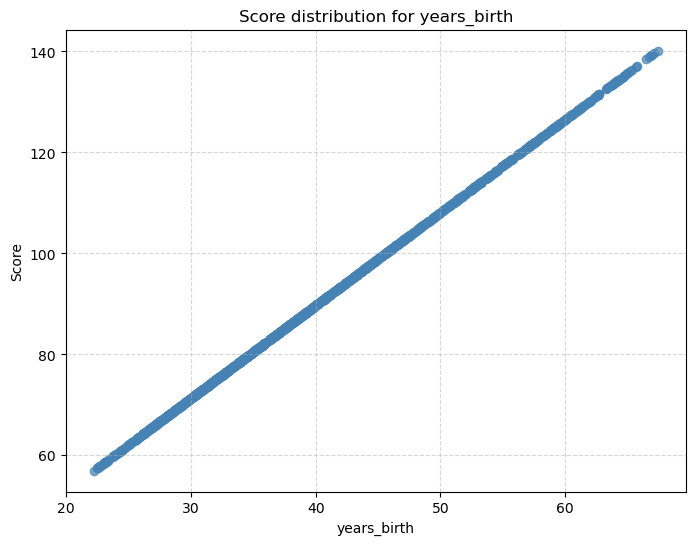

In [555]:
var='years_birth'
plt.figure(figsize=(8, 6))
plt.scatter(test_data[var], df_score[var], color='steelblue', alpha=0.7)
plt.title("Score distribution for "+str(var))
plt.xlabel(var)
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()